# Analyzing the ClimEx Large Ensemble

[ClimEx](https://www.climex-project.org/) is a project investigating the influence of climate change on hydro-meteorological extremes. To understand the effect of natural variability on the occurrence of rare extreme events, ClimEx ran 50 independent simulations, increasing the sample size available.

Analyzing simulation outputs from large ensembles can get tedious due to the large number of individual netCDF files to handle. To simplify data access, we've created an aggregated view of daily precipitation and temperature for all 50 ClimEx realizations from 1955 to 2100.

The first step is to open the dataset, whose path can be found in the `climex` catalog. Although there are 435,000 individual netCDF files, there is only one link in the catalog.

In [1]:
import xarray as xr
import intake
import xclim
from dask.diagnostics import ProgressBar

cat = intake.open_esm_datastore("https://pavics.ouranos.ca/catalog/climex.json")  # TEST_USE_PROD_DATA
cat.df.head()

,license_type,title,institution,driving_model_id,driving_experiment,type,processing,project_id,frequency,modeling_realm,variable_name,variable_long_name,path
0,permissive non-commercial,The ClimEx CRCM5 Large Ensemble,Ouranos Consortium on Regional Climatology and...,CCCma-CanESM2,"historical, rcp85",RCM,raw,CLIMEX,day,atmos,"['rotated_pole', 'tasmin', 'tasmax', 'tas', 'p...","['NA', 'Daily Minimum Near-Surface Temperature...",https://pavics.ouranos.ca/twitcher/ows/proxy/t...


In [2]:
# NBVAL_IGNORE_OUTPUT
# Opening the link takes a while, because the server creates an aggregated view of 435,000 individual files.
url = cat.df.path[0]
ds = xr.open_dataset(url, chunks=dict(realization=2, time=30*3))
ds

<xarray.Dataset>
Dimensions:       (rlat: 280, rlon: 280, time: 52924, realization: 50)
Coordinates:
  * rlat          (rlat) float64 -12.61 -12.51 -12.39 ... 17.85 17.96 18.07
  * rlon          (rlon) float64 2.695 2.805 2.915 3.025 ... 33.17 33.28 33.39
  * time          (time) object 1955-01-01 00:00:00 ... 2099-12-30 00:00:00
  * realization   (realization) |S64 b'historical-r1-r10i1p1' ... b'historica...
    lat           (rlat, rlon) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
    lon           (rlat, rlon) float32 dask.array<chunksize=(280, 280), meta=np.ndarray>
Data variables:
    rotated_pole  (time) |S64 dask.array<chunksize=(90,), meta=np.ndarray>
    tasmin        (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
    tasmax        (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
    tas           (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
    pr            (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
    prsn          (realization, time, rlat, rlon) float32 dask.array<chunksize=(2, 90, 280, 280), meta=np.ndarray>
Attributes: (12/29)
    Conventions:           CF-1.6 
    DODS.dimName:          string1
    DODS.strlen:           1
    EXTRA_DIMENSION.bnds:  2
    NCO:                   "4.5.2"
    abstract:              The ClimEx CRCM5 Large Ensemble of high-resolution...
    ...                    ...
    product:               output 
    project_id:            CLIMEX
    rcm_version_id:        v3331 
    terms_of_use:          http://www.climex-project.org/sites/default/files/...
    title:                 The ClimEx CRCM5 Large Ensemble
    type:                  RCM

The ClimEx dataset stores 5 daily variables, simulated by CRCM5 driven by CanESM2 using the representative concentration pathway RCP8.5:
- `pr`: mean daily precipitation flux
- `prsn`: mean daily snowfall flux
- `tas`: mean daily temperature
- `tasmin`: minimum daily temperature
- `tasmax`: maximum daily temperature

There variables are stored along spatial dimensions (rotated latitude and longitude), time (1955-2100) and realizations (50 members). These members are created by first running five members from CanESM2 from 1850 to 1950, then small perturbations are applied in 1950 to spawn 10 members from each original member, to yield a total of 50 global realizations. Each realization is then dynamically downscaled to 12 km resolution over Québec.

<div>
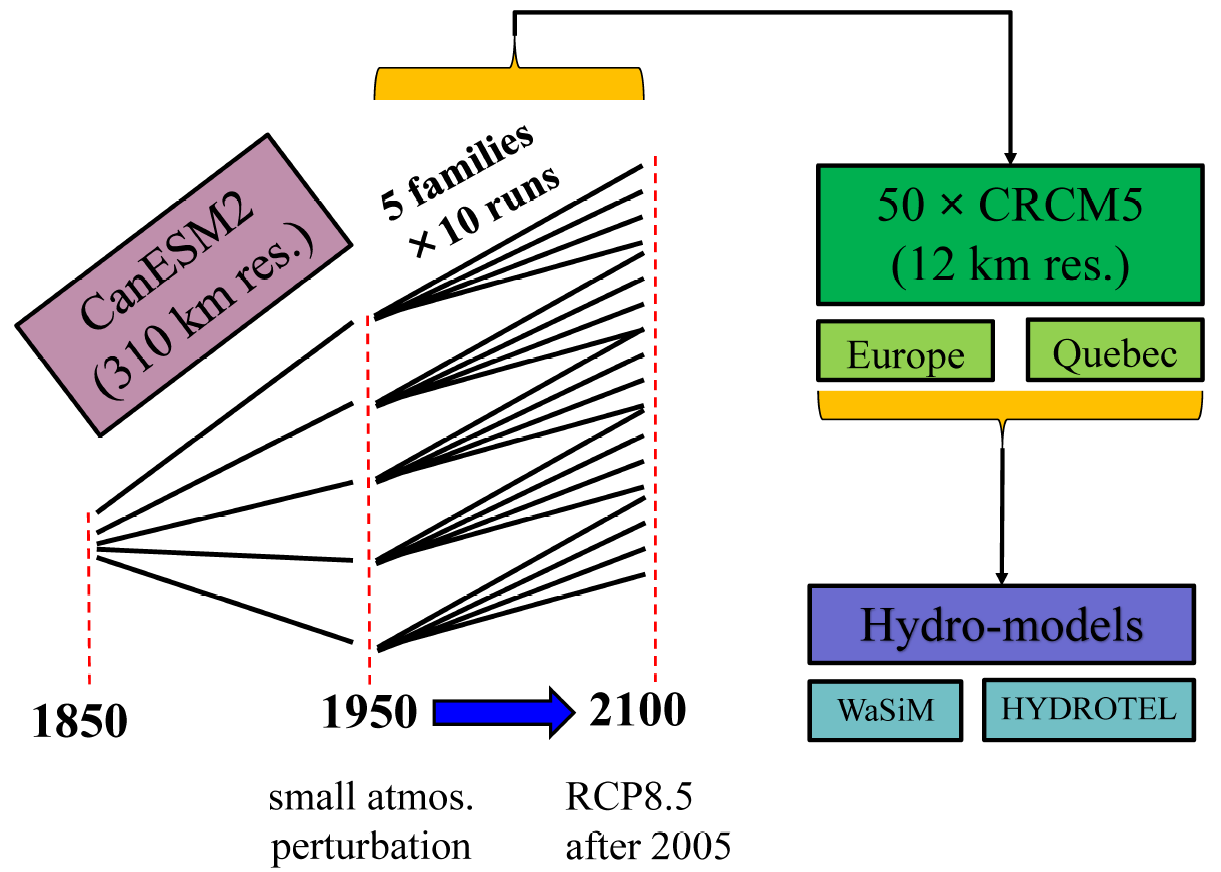
</div>


In [3]:
# NBVAL_IGNORE_OUTPUT
ds.realization[:5].data.tolist()

[b'historical-r1-r10i1p1',
 b'historical-r1-r1i1p1',
 b'historical-r1-r2i1p1',
 b'historical-r1-r3i1p1',
 b'historical-r1-r4i1p1']

# Creating maps of ClimEx fields

The data is on a rotated pole grid, and the actual geographic latitudes and longitudes of grid centroids are stored in the variables with the same name. We can plot the data directly using the native `rlat` and `rlon` coordinates easily.

[########################################] | 100% Completed |  1.4s


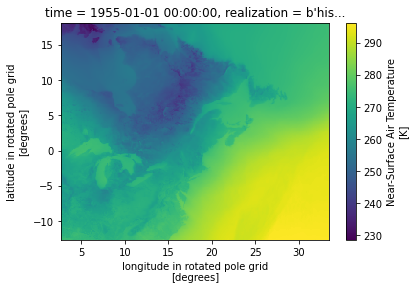

In [4]:
# NBVAL_IGNORE_OUTPUT
from matplotlib import pyplot as plt
with ProgressBar():
    field = ds.tas.isel(time=0, realization=0).load()
    field.plot()

However, the axes are defined with respect to the rotated coordinates. To create a map with correct geographic coordinates, we could use the real longitudes and latitudes (`plt.pcolormesh(ds.lon, ds.lat, field)`), but a better option is to create axes with the same projection used by the model. That is, we set the map projection to `RotatedPole`, using the coordinate reference system defined in the `rotated_pole` variable. We can use a similar approach to project the model output on another projection.

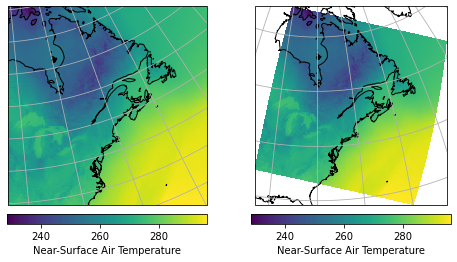

In [5]:
# NBVAL_IGNORE_OUTPUT
import cartopy.crs as ccrs
with ProgressBar():
    # The CRS for the rotated pole (data)
    rotp = ccrs.RotatedPole(pole_longitude=ds.rotated_pole.grid_north_pole_longitude,
                           pole_latitude=ds.rotated_pole.grid_north_pole_latitude)

    # The CRS for your map projection (can be anything)
    ortho = ccrs.Orthographic(central_longitude=-80, central_latitude=45)

    fig = plt.figure(figsize=(8, 4))

    # Plot data on the rotated pole projection directly
    ax = plt.subplot(1, 2, 1, projection=rotp)
    ax.coastlines()
    ax.gridlines()
    m = ax.pcolormesh(ds.rlon, ds.rlat, field, shading='auto')
    plt.colorbar(m, orientation='horizontal', label=field.long_name, fraction=0.046, pad=0.04)

    # Plot data on another projection, transforming it using the rotp crs.
    ax = plt.subplot(1, 2, 2, projection=ortho)
    ax.coastlines()
    ax.gridlines()
    m = ax.pcolormesh(ds.rlon, ds.rlat, field, transform=rotp, shading='auto')  # Note the transform parameter
    plt.colorbar(m, orientation='horizontal', label=field.long_name, fraction=0.046, pad=0.04)

    plt.show()

# Computing climate indicators

Next we'll compute a climate indicator over a small data subset as an example. We'll compute the mean precipitation intensity for 2 members over the January 2000, then compute the ensemble mean. The amount of data that we'll be requesting is however to big to go over the network in one request. To work around this, we need to first chunk the data in smaller bites.

This has also the effect of making further computations on these chunks *lazy*. The next cell is thus going to execute almost instantly, because no data is transferred, and no computation executed. The actual work happens when the data is actually needed, as when plotting graphics, saving to file, or when requested explicitly by calling the `compute` or `load` methods.

In [6]:
# This will return instantaneously, because xclim is using lazy evaluation whenever possible.
sdii = xclim.atmos.daily_pr_intensity(ds.pr.isel(realization=[4,5], rlat=slice(100, 200), rlon=slice(100, 200)).sel(time="2020"), freq="YS")

In [7]:
# NBVAL_IGNORE_OUTPUT
# This will trigger the computation. Be patient, this will take some time.
with ProgressBar():
    out = sdii.load()

[########################################] | 100% Completed | 24.5s


Text(0.5, 1.0, 'Ensemble mean')

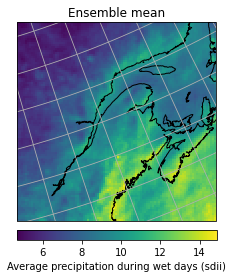

In [8]:
fig = plt.figure(figsize=(8, 4))

ax = plt.subplot(1, 1, 1, projection=rotp)
ax.coastlines()
ax.gridlines()
m = ax.pcolormesh(out.rlon, out.rlat, out.mean(dim="realization").isel(time=0), shading='auto')
plt.colorbar(m, orientation='horizontal', label=sdii.long_name, fraction=0.046, pad=0.04)
ax.set_title("Ensemble mean")

As you can see, execution is fairly slow, and we believe this is due to the THREDDS server limitations. We're investigating  solutions to speed this type of calculations. The access time issue is especially problematic with time series analysis. In the next example, we extract one grid point over Montréal and then extract the time series. The data extraction cell is commented out because it takes around 6 minutes to complete.   

In [9]:
# NBVAL_IGNORE_OUTPUT
# Subset over the Montreal gridpoint
# We cannot select using sel directly, because coordinates are in rotated pole coordinates.
from clisops.core.subset import subset_gridpoint
mtl = subset_gridpoint(ds, lon=-73.57, lat=45.50)
mtl

<xarray.Dataset>
Dimensions:       (time: 52924, realization: 50)
Coordinates:
    rlat          float64 0.475
    rlon          float64 16.23
  * time          (time) object 1955-01-01 00:00:00 ... 2099-12-30 00:00:00
  * realization   (realization) |S64 b'historical-r1-r10i1p1' ... b'historica...
    lat           float32 45.52
    lon           float32 -73.5
Data variables:
    rotated_pole  (time) |S64 dask.array<chunksize=(90,), meta=np.ndarray>
    tasmin        (realization, time) float32 dask.array<chunksize=(2, 90), meta=np.ndarray>
    tasmax        (realization, time) float32 dask.array<chunksize=(2, 90), meta=np.ndarray>
    tas           (realization, time) float32 dask.array<chunksize=(2, 90), meta=np.ndarray>
    pr            (realization, time) float32 dask.array<chunksize=(2, 90), meta=np.ndarray>
    prsn          (realization, time) float32 dask.array<chunksize=(2, 90), meta=np.ndarray>
Attributes: (12/29)
    Conventions:           CF-1.6 
    DODS.dimName:          string1
    DODS.strlen:           1
    EXTRA_DIMENSION.bnds:  2
    NCO:                   "4.5.2"
    abstract:              The ClimEx CRCM5 Large Ensemble of high-resolution...
    ...                    ...
    product:               output 
    project_id:            CLIMEX
    rcm_version_id:        v3331 
    terms_of_use:          http://www.climex-project.org/sites/default/files/...
    title:                 The ClimEx CRCM5 Large Ensemble
    type:                  RCM

In [10]:
# Compute the seasonal average temperature
# Here we're only loading data for two years and 5 members, because loading the full 150 years would take many hours.
# with ProgressBar():
#     seas_mean_ts = xclim.atmos.tg_mean(mtl.tas.isel(realization=slice(None, 5)).sel(time=slice("2010","2011")), freq='QS-DEC').load()
# Select the summer months (JJA)
# jja = seas_mean_ts.isel(time=(seas_mean_ts.time.dt.month == 6))
# jja.plot(hue="realization")
